Plan

1. Preprocess data

2. Find variables with high correlation with tip amount variable

3. Use a RandomForestRegressor + RandomizedSearchCV to build a prediction model

4. Find feature importance of variables after model is finished training

5. Summarize results

# Data preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root = './drive/MyDrive/Colab Notebooks/ADA-1005-Project'

In [ ]:
import pandas as pd

# concatenate all files into single dataframe
# alldata = (pd.read_parquet(f"cleaned_data/1.parquet")).head(1500000)
alldata = pd.DataFrame()
frames = []
for i in range(1, 13):
  data = pd.read_parquet(f"{root}/{i}.parquet").head(1500000)
  frames.append(data)
alldata = pd.concat(frames)

In [ ]:
# turn date-time into numerical values
alldata['tpep_pickup_datetime'] = pd.to_datetime(alldata['tpep_pickup_datetime']).astype('int64') // 1e9
alldata['tpep_dropoff_datetime'] = pd.to_datetime(alldata['tpep_dropoff_datetime']).astype('int64') // 1e9

In [ ]:
# turn 'N' and 'Y' into 0 and 1
alldata["store_and_fwd_flag"] = alldata["store_and_fwd_flag"].map(lambda x: 0 if x == "N" else 1)

In [ ]:
# drop unwanted columns
alldata = alldata.drop(columns=["yyyy-mm", "Airport_fee", "total_amount"])

# fillNA with zeroes
alldata["airport_fee"] = alldata["airport_fee"].fillna(0.00)

In [ ]:
# one-hot encode nominal categories
alldata = pd.get_dummies(alldata, columns=['VendorID', 'RatecodeID', 'payment_type'], prefix_sep='_', dtype=int)

In [ ]:
# drop some redundant columns
alldata = alldata.drop(columns=['improvement_surcharge', 'payment_type_5', 'store_and_fwd_flag'])

In [ ]:
alldata.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,extra,mta_tax,tip_amount,...,RatecodeID_2.0,RatecodeID_3.0,RatecodeID_4.0,RatecodeID_5.0,RatecodeID_6.0,RatecodeID_99.0,payment_type_1,payment_type_2,payment_type_3,payment_type_4
0,1672533.0,1672533.0,1.0,0.97,161,141,9.3,1.00,0.5,0.00,...,0,0,0,0,0,0,0,1,0,0
1,1672534.0,1672534.0,1.0,1.10,43,237,7.9,1.00,0.5,4.00,...,0,0,0,0,0,0,1,0,0,0
2,1672532.0,1672533.0,1.0,2.51,48,238,14.9,1.00,0.5,15.00,...,0,0,0,0,0,0,1,0,0,0
3,1672531.0,1672532.0,0.0,1.90,138,7,12.1,7.25,0.5,0.00,...,0,0,0,0,0,0,1,0,0,0
4,1672531.0,1672532.0,1.0,1.43,107,79,11.4,1.00,0.5,3.28,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
# drop the values with negative tip_amount/fare_amount
alldata = alldata[(alldata['fare_amount'] >= 0) & (alldata['tip_amount'] >= 0)]
# # Sort the DataFrame by 'tip_amount'
# alldata_sorted = alldata[(alldata['fare_amount'] >= 0) & (alldata['tip_amount'] >= 0)].sort_values(by='tip_amount')
# # Display the sorted data
# alldata_sorted

# Variable Correlations

In [ ]:
!pip install seaborn

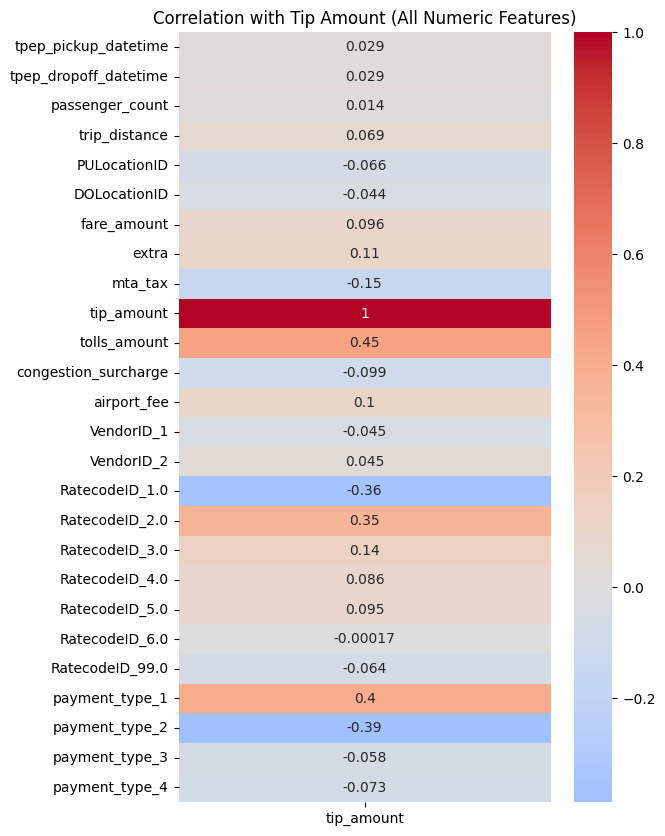

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select all numeric columns (both float and integer types)
numericals = alldata.select_dtypes(include=['number'])

# Calculate correlations with tip_amount
corr = numericals.corr()[['tip_amount']]

# Plot heatmap
plt.figure(figsize=(6, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation with Tip Amount (All Numeric Features)')
plt.show()

# Build a Random Forest model

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import randint
from sklearn.decomposition import PCA

# Load data and split into features and target
X = alldata.drop("tip_amount", axis=1)
y = alldata["tip_amount"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Reduce dimensionality to using PCA
pca = PCA(n_components=10, random_state=0)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Reduce the data size for faster exploration to 5%
subset_size = int(0.05 * len(X_train))
subset_idx = np.random.choice(X_train_pca.shape[0], subset_size, replace=False)
X_subset = X_train_pca[subset_idx]
y_subset = y_train.iloc[subset_idx]

# Initialize the Random Forest Regressor
forest = RandomForestRegressor(random_state=0, max_features=9, n_jobs=8)

# Define hyperparameter search space
# param_dist = {
#     'n_estimators': randint(100, 250),
#     'max_depth': [None, 10, 20, 30, 50],
#     'min_samples_split': randint(2, 7),
#     'min_samples_leaf': randint(1, 5)
# }

param_dist = {
    'n_estimators': [188],
    'max_depth': [20],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
}


# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=forest,
    param_distributions=param_dist,
    n_iter=3,
    cv=2,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=0,
    n_jobs=-1
)

# Train the model on the PCA-transformed data
random_search.fit(X_subset, y_subset)
print(f'Best Parameters: {random_search.best_params_}')

# Embed the reduced data back (approximation)
X_train_reconstructed = pca.inverse_transform(X_train_pca)
X_test_reconstructed = pca.inverse_transform(X_test_pca)

# Optional: Evaluate the model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_pca)
mse = mean_squared_error(y_test, y_pred)
print(f'Test MSE: {mse}')

Fitting 2 folds for each of 2 candidates, totalling 4 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=3. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'n_estimators': 188, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
Test MSE: 9.670160122132367


In [ ]:
# Use the Best Model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_subset)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_subset, y_pred))
print(f'RMSE: {rmse:.2f}')

RMSE: 2.26


Extract the important features

In [ ]:
# Get feature importances for the PCA components
pca_importances = best_model.feature_importances_  # Shape:

# Map importances back to original features using PCA loadings (components_)
original_feature_importances = np.dot(pca_importances, pca.components_)  # Shape:

In [ ]:
# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': original_feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

print(importance_df)

                  Feature    Importance
6             fare_amount  5.846327e-01
9            tolls_amount  8.255076e-02
3           trip_distance  7.086432e-02
0    tpep_pickup_datetime  6.638534e-02
7                   extra  6.604190e-02
4            PULocationID  5.680568e-02
5            DOLocationID  2.496979e-02
1   tpep_dropoff_datetime  1.112653e-02
15         RatecodeID_2.0  2.663514e-03
12             VendorID_1  2.077912e-03
16         RatecodeID_3.0  8.580443e-04
11            airport_fee  5.256175e-04
21         payment_type_1  4.149898e-04
2         passenger_count  2.266869e-04
18         RatecodeID_5.0  1.910245e-04
17         RatecodeID_4.0  1.313054e-04
23         payment_type_3  1.886592e-05
19         RatecodeID_6.0  1.527321e-08
24         payment_type_4 -1.916310e-06
20        RatecodeID_99.0 -2.182100e-05
22         payment_type_2 -4.319383e-04
8                 mta_tax -5.792269e-04
13             VendorID_2 -2.077912e-03
10   congestion_surcharge -3.473243e-03


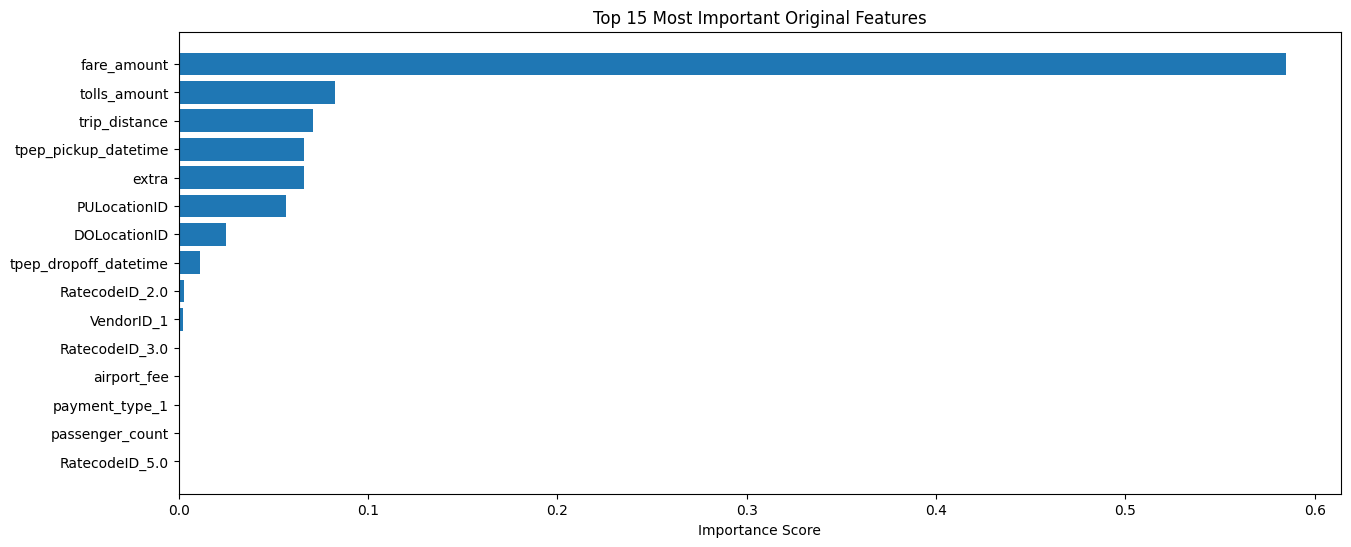

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15])
plt.gca().invert_yaxis()  # Most important at top
plt.xlabel('Importance Score')
plt.title('Top 15 Most Important Original Features')
plt.show()